In [ ]:
!pip install s3fs
import fsspec
import s3fs

In [45]:
import datetime
import dateutil

# this is the data that is available in the S3 bucket
KNOWN_MODELS = ['enukx']
KNOWN_DIAGNOSTICS = [
    'temperature_at_screen_level',
]
START_CYCLE = '20190101T0000Z'
END_CYCLE = '20190131T2300Z'

In [46]:
def timedelta_to_duration_str(td):
    minutes, seconds = divmod(td.seconds, 60)
    hours, minutes = divmod(minutes, 60)
    hours += td.days*24
    assert seconds == 0
    return f'PT{hours:04}H{minutes:02}M'

def datetime_to_iso_str(dt):
    return dt.strftime('%Y%m%dT%H%MZ')

In [47]:
def calc_cycle_validity_lead_times(cycle_time=None, validity_time=None, lead_time=None):
    num_inputs = sum(map(lambda x: 1 if x else 0, [cycle_time, validity_time, lead_time]))
    if num_inputs != 2:
       # raise RuntimeError('Expected 2 of cycle_time, validity_time and lead_time')
        pass
    if not validity_time:
        validity_time = cycle_time + lead_time
    elif not cycle_time:
        cycle_time = validity_time - lead_time
    elif not lead_time:
        lead_time = validity_time - cycle_time
    return cycle_time, validity_time, lead_time

In [48]:
def get_image_url(model, diagnostic,
                  cycle_time=None, validity_time=None, lead_time=None):
    # model and diagnostic are strings
    # validity_time (datetime.datetime)
    # lead_time (datetime.timedelta)
    
    assert model in KNOWN_MODELS
    assert diagnostic in KNOWN_DIAGNOSTICS
    
    # determine all times
    cycle_time, validity_time, lead_time = calc_cycle_validity_lead_times(
        cycle_time, validity_time, lead_time
    )
    
    # convert all to strings
    cycle_time = datetime_to_iso_str(cycle_time)
    validity_time = datetime_to_iso_str(validity_time)
    lead_time = timedelta_to_duration_str(lead_time)
    
    filepath = f'fcst_images/level_1/{model}/{cycle_time}/{validity_time}-{lead_time}-{diagnostic}.png'
    return f's3://{BUCKET_NAME}/{filepath}'

In [49]:
def read_from_url(url, **storage_options):
    # use fsspec to read file into memory
    with fsspec.open(url, 'rb', **storage_options) as of:
        data = of.read()
    return data

In [50]:
from PIL import Image
from io import BytesIO

In [51]:
# URL Pairs for forecast and observations
# with 12 hours lead time for forecasts i.e. start-time for Cycle is 01-01-2019 at 12:00 noon
# corresponding truth value is at 01-01-2019 at 12:00 am 
# There are a total of 24 time steps each day for 30 days = 720 
# plus 12 time steps on Jan 1st (which started at noon) = 732 Url pairs. These are the validity times.

import pandas as pd

#creating datetime object containing all my validity times
validity_times = list(pd.date_range(start = '20190101T1200Z', end = '20190131T2300Z', freq='1h'))
forecast_urls = []
truth_urls = []
url_list2 = []

for time_steps in validity_times:
    time_steps = time_steps.to_pydatetime() # convert timestamp to datetime https://www.statology.org/pandas-timestamp-to-datetime/
    image_urlforecast = get_image_url(model='enukx', # generating the forecast Urls
                          diagnostic='temperature_at_screen_level',
                          validity_time=time_steps,
                          lead_time=datetime.timedelta(hours=12))
    image_urltruth = get_image_url(model='enukx', # generating the truth Urls
                          diagnostic='temperature_at_screen_level',
                          validity_time=time_steps,
                          lead_time=datetime.timedelta(hours=0))
    forecast_urls.append(image_urlforecast)
    truth_urls.append(image_urltruth)
    url_list2.append([image_urlforecast, image_urltruth])

In [52]:
from pandas import DataFrame
df_image_urls = DataFrame (url_list2,columns=['forecast_urls','truth_urls'])

In [53]:
def get_json_url(model, diagnostic, cycle_time):
    cycle_time = datetime_to_iso_str(cycle_time)
    filepath = f'fcst_images/level_1/{model}/{cycle_time}/{diagnostic}.json'
    return f's3://{BUCKET_NAME}/{filepath}'

In [54]:
#SPLITTING THE DATASET FIRST INTO TRAINING AND TEST

training_data = df_image_urls[:int(df_image_urls.shape[0]*0.803279)]
testing_data = df_image_urls[int(df_image_urls.shape[0]*0.803279):]

print(f"No. of training samples: {training_data.shape[0]}") #588 for batch size 12 = 49 batches
print(f"No. of testing samples: {testing_data.shape[0]}") #144 for batch size 12 = 12 batches


No. of training samples: 588
No. of testing samples: 144


In [55]:
#FURTHER SPLITTING TRAINING DATA INTO TRAINNING AND VALIDATION SETS
training_data_split = training_data[:int(training_data.shape[0]*0.77551)]
validation_data = training_data[int(training_data.shape[0]*0.77551):]

print(f"No. of validation samples: {training_data_split.shape[0]}") #455 for batch size 12 = 38 batches
print(f"No. of validation samples: {validation_data.shape[0]}") #133 for batch size 12 = 11 batches

No. of validation samples: 455
No. of validation samples: 133


In [56]:
forecast_urls_train = training_data_split['forecast_urls'].values.tolist()
truth_urls_train = training_data_split['truth_urls'].values.tolist()

forecast_urls_vald = validation_data['forecast_urls'].values.tolist()
truth_urls_vald = validation_data['truth_urls'].values.tolist()

forecast_urls_test = testing_data['forecast_urls'].values.tolist()
truth_urls_test = testing_data['truth_urls'].values.tolist()

#forecast_urls_train[587], truth_urls_train[587], forecast_urls_test[0], truth_urls_test[0]


In [60]:
forecast_urls_train[0]

's3://mo-exeter-collab/fcst_images/level_1/enukx/20190101T0000Z/20190101T1200Z-PT0012H00M-temperature_at_screen_level.png'

In [61]:
truth_urls_train[0]

's3://mo-exeter-collab/fcst_images/level_1/enukx/20190101T1200Z/20190101T1200Z-PT0000H00M-temperature_at_screen_level.png'

In [16]:
import numpy as np

#Saving the values obtained from calculating mean and SD for standardizing
#Xmean, ymean, Xstdev, ystdev
#(279.2222502788791, 279.14195960409154, 4.864251560679521, 4.915170531644156) #values for training data set

#Saving the values obtained from calculating min and max 
#Xmin3, ymin3, Xmax3, ymax3
#(231.34646606445312, 230.29400634765625, 289.9052734375, 288.4958190917969)

#Saving the values obtained from calculating min and max after standardizing 
#Xmin, ymin, Xmax, ymax
#-9.842374231101207, -9.938201114681434, 2.196231635094247, 1.903058994084669

In [41]:
# 2ND WORKING SEQUENCE WITH IMAGE IN RANGE OF THE ORIGINAL DATAfrom tensorflow.keras.utils import Sequence
# use this sequence to get the data back in original scale. Also use to calculate mean and SD for standardizing the data
import json
import os

class ImgSequence(Sequence):
    def __init__(self, forecast_urls_list, truth_urls_list, batch_size=2, dim=(120,120), n_channels=3, shuffle=True):
        self.forecasts, self.truths = forecast_urls_list, truth_urls_list
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle

    def __len__(self):
        return int(np.ceil(len(self.forecasts) / float(self.batch_size)))
# Counts the number of possible batches that can be made from the total available datasets in forecast_imgs
# Rule of thumb, number of datasets % batch_size = 0, so that every sample is seen
# for 732 sets of data and batch size 10, __len__() will return 73 i.e. 73 unique batches available
# each batch is assigned an index from 0 to 72 and this is used in the __getitem__() method
    
    def __getitem__(self, idx):
        batch_x = self.forecasts[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.truths[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        X = self.__data_generation(batch_x)
        y = self.__data_generation(batch_y)
        return X, y

#__getitem__() is called when model needs a new batch of data. For requested batch with index 121,
# method will extract datasets from forecast_urls_list that have the index 121 * 10 to (121 + 1)*10

    @staticmethod
    def __read_scaled_image(image_url):
        # read image data
        file_data = read_from_url(image_url, **STORAGE_OPTIONS)
        img = Image.open(BytesIO(file_data))
        arr = np.array(img)

        # construct json url
        # split image_url into dirname and basename
        dirname, basename = os.path.split(image_url)
        # remove extension from basename
        basename, _ = os.path.splitext(basename)
        # diagnostic is the component in the string before the extension
        diagnostic = basename.split('-')[-1]
        json_url = f'{dirname}/{diagnostic}.json'

        # read scaling data from json file
        json_data = read_from_url(json_url, **STORAGE_OPTIONS)
        json_data = json.loads(json_data)
        image_name = os.path.basename(image_url)
        image_data_bounds = json_data[image_name]
        # convert values (lists) to numpy arrays
        image_data_bounds = {k: np.array(v)
                            for k, v in image_data_bounds.items()}

        # rescale image
        arr_scaled = arr.astype(np.float32)
        # rescale in range 0 to 1
        arr_scaled = (arr - arr.min(axis=(0,1))) / (arr.max(axis=(0,1)) - arr.min(axis=(0,1)))
        # put on range of output data
        arr_scaled = (arr_scaled * (image_data_bounds['max'] - image_data_bounds['min'])
                      + image_data_bounds['min'])
        arr_scaled = arr_scaled[532:652, 473:593]
        return arr_scaled
    
    def __data_generation(self, batch_urls):

            # Creates an empty placeholder array that will be populated with data that is to be supplied
            #X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.float32)
            #X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.uint8)
            X = np.empty((self.batch_size, *self.dim, self.n_channels))
            #outfile = TemporaryFile()

            for i, url in enumerate(batch_urls):
                X[i, ] = self.__read_scaled_image(url)
                #np.savez(outfile, X) # https://numpy.org/doc/stable/reference/generated/numpy.savez.html, https://numpy.org/doc/stable/reference/generated/numpy.load.html
                
                
            return X#, y
        


In [16]:
#Use the test (FORECAST) URls FOR PLOTS AND ANALYSIS and quick tests on ImgSequence
test_urls = forecast_urls_train[0:5]
test_img_forecast = []
test_arr_forecast = []
for url in test_urls:
    x_file_data = read_from_url(url, **STORAGE_OPTIONS)
    x_img = Image.open(BytesIO(x_file_data))
    test_img_forecast.append(x_img)
    x_arr = np.array(x_img)
    test_arr_forecast.append(x_arr)



In [69]:
#Use the test (TRUTH) URls FOR PLOTS AND ANALYSIS and quick tests on ImgSequence
test_urls2 = truth_urls_train[0:5]
test_img_truth = []
test_arr_truth = []
for url in test_urls2:
    y_file_data = read_from_url(url, **STORAGE_OPTIONS)
    y_img = Image.open(BytesIO(y_file_data))
    test_img_truth.append(y_img)
    y_arr = np.array(y_img)
    test_arr_truth.append(y_arr)

In [24]:
img_test = ImgSequence(test_urls, test_urls2, batch_size=2, dim=(120,120), n_channels=3, shuffle=True)#, rescale_mean=279.2222502788791,rescale_Xstdev=4.864251560679521,rescale_ymean=279.14195960409154,rescale_ystdev=4.915170531644156)
#img_test = ImgSequence4(test_urls, test_urls2, batch_size=2, dim=(970,1042), n_channels=3, shuffle=True, rescale_mean=279.2222502788791,rescale_Xstdev=4.864251560679521,rescale_ymean=279.14195960409154,rescale_ystdev=4.915170531644156)

In [31]:
batch0 = img_test[0]
batch_x, batch_y = batch0
batch_x.shape
#len(img_test)

In [52]:
#Function Calculates the mse - further test of the variation between the forecast and observation
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float32") - imageB.astype("float32")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

bx0 = batch_x[0]
by0 = batch_y[0]
bx1 = batch_x[1]
by1 = batch_y[1]

mse(bx0,by0), mse(bx1,by1) #(2.2230031956784138, 2.214571749411322) #(1.3810590507944673, 2.1197439499772446)

(1.1831981065538195, 1.2438053385416667)

In [63]:
taf0 = test_arr_forecast[0][532:652, 473:593]
tat0 = test_arr_truth[0][532:652, 473:593]
taf1 = test_arr_forecast[1][532:652, 473:593]
tat1 = test_arr_truth[1][532:652, 473:593]
mse(taf0,tat0), mse(taf1,tat1) #(312.2498921582207, 246.6616538377822) values for full img #(221.77631944444445, 124.47673611111111) values for wales cut-out

(221.77631944444445, 124.47673611111111)

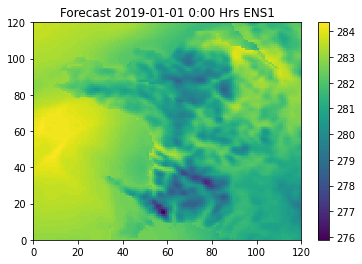

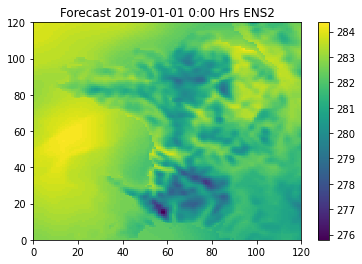

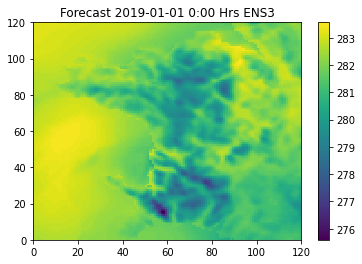

In [55]:
#A cut out of Wales showing temperatures forecast for three ensemble members
#FORECAST
#cutout = arr_scaled[532:652, 473:593]
#wales = batch_x[0][532:652, 473:593]
import matplotlib.pyplot as plt
for batch_index in range(3):
    plt.pcolormesh(bx0[:,:,batch_index])
    caption = 'Forecast 2019-01-01 0:00 Hrs ENS'+str(batch_index+1)
    plt.title(caption)
    plt.colorbar()
    plt.show()


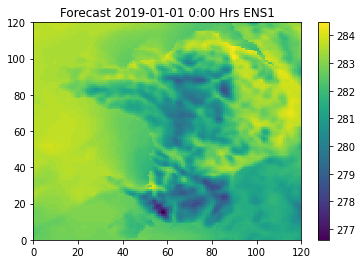

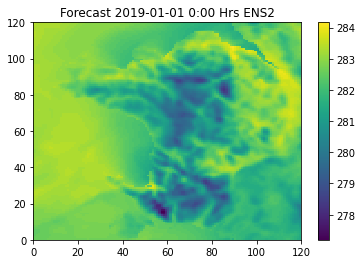

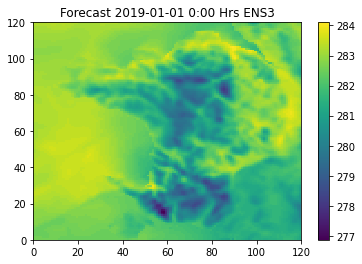

In [57]:
#TRUTH
#wales = batch_y[0][532:652, 473:593]
for batch_index in range(3):
    plt.pcolormesh(by0[:,:,batch_index])
    caption = 'Forecast 2019-01-01 0:00 Hrs ENS'+str(batch_index+1)
    plt.title(caption)
    plt.colorbar()
    plt.show()

In [62]:
#calculating the mean and SD for standardizing data
import math

batch_Xsums = []
batch_ysums = []
batch_Xnum_elements = []
batch_ynum_elements = []

for X,y in ImgSequence(forecast_urls_train, truth_urls_train, batch_size=12):
    batch_Xsums.append(X.sum())
    batch_ysums.append(y.sum())

    batch_Xnum_elements.append(np.shape(X)[0] * np.shape(X)[1] * np.shape(X)[2] * np.shape(X)[3])
    batch_ynum_elements.append(np.shape(y)[0] * np.shape(y)[1] * np.shape(y)[2] * np.shape(y)[3])

Xmean = np.sum(batch_Xsums)/np.sum(batch_Xnum_elements)
ymean = np.sum(batch_ysums)/np.sum(batch_ynum_elements)

Xmean, ymean #278.40751329128517, 278.54763033652455

#training_data is the full training data 
#split into forecast_urls_train and forecast_urls_vald

(278.40751329128517, 278.54763033652455)

In [84]:
batch_Xsubmean = []
batch_ysubmean = []
for X, y in ImgSequence(forecast_urls_train, truth_urls_train, batch_size=12):
    batch_Xsubmean.append(np.sum((X - Xmean)**2))
    batch_ysubmean.append(np.sum((y - ymean)**2))

Xstdev = math.sqrt(np.sum(batch_Xsubmean) / np.sum(batch_Xnum_elements))
ystdev = math.sqrt(np.sum(batch_ysubmean) / np.sum(batch_ynum_elements))

Xstdev,ystdev # (13.506688794260096, 13.471262058577377)

(13.506688794260096, 13.471262058577377)

In [ ]:
# 4TH WORKING SEQUENCE WITH SCALED DATA (STANDARDIZED) THIS IS FINAL SEQUENCE WHICH IS USED IN THE NEURAL NETWORK MODEL
from tensorflow.keras.utils import Sequence
import json
import os
class ImgSequence4(Sequence):
    def __init__(self, forecast_urls_list, truth_urls_list, batch_size=12, dim=(120,120), n_channels=3, shuffle=True,
                dataset_name=None, rescale_Xmean=278.40751329128517,rescale_Xstdev=13.506688794260096,rescale_ymean=278.54763033652455,rescale_ystdev=13.471262058577377):
        self.forecasts, self.truths = forecast_urls_list, truth_urls_list
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        #self.on_epoch_end()
        
        self.dataset_name = dataset_name
        self.rescale_Xmean, self.rescale_Xstdev = rescale_Xmean, rescale_Xstdev
        self.rescale_ymean, self.rescale_ystdev = rescale_ymean, rescale_ystdev
    
   # def on_epoch_end(self):
      #self.indexes = np.arange(len(self.list_IDs))
      #if self.shuffle == True:
        #np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.forecasts) / float(self.batch_size)))
# Counts the number of possible batches that can be made from the total available datasets in forecast_imgs
# Rule of thumb, number of datasets % batch_size should equal = 0, so that every sample is seen
# for 732 sets of data and batch size 12, __len__() will return 61 i.e. 61 unique batches available
# each batch is assigned an index from 0 to 61 and this is used in the __getitem__() method
    
    def __getitem__(self, idx):
        batch_x = self.forecasts[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.truths[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        X = self.__data_generation(batch_x)
        y = self.__data_generation(batch_y)
        
        if self.rescale_Xmean is not None and self.rescale_Xstdev is not None:
            X -= self.rescale_Xmean
            X /= self.rescale_Xstdev
        if self.rescale_ymean is not None and self.rescale_ystdev is not None:
            y -= self.rescale_ymean
            y /= self.rescale_ystdev
            
        return X.mean(axis=3), y.mean(axis=3)
       
#__getitem__() is called when model needs a new batch of data. For requested batch with index 121,
# method will extract datasets from forecast_urls_list or truth_urls_list that have the index 121 * 10 to (121 + 1)*10

    @staticmethod
    def __read_scaled_image(image_url):
        # read image data
        file_data = read_from_url(image_url, **STORAGE_OPTIONS)
        img = Image.open(BytesIO(file_data))
        arr = np.array(img)

        # construct json url
        # split image_url into dirname and basename
        dirname, basename = os.path.split(image_url)
        # remove extension from basename
        basename, _ = os.path.splitext(basename)
        # diagnostic is the component in the string before the extension
        diagnostic = basename.split('-')[-1]
        json_url = f'{dirname}/{diagnostic}.json'

        # read scaling data from json file
        json_data = read_from_url(json_url, **STORAGE_OPTIONS)
        json_data = json.loads(json_data)
        image_name = os.path.basename(image_url)
        image_data_bounds = json_data[image_name]
        # convert values (lists) to numpy arrays
        
        image_data_bounds = {k: np.array(v)
                            for k, v in image_data_bounds.items()}

        # rescale image
        arr_scaled = arr.astype(np.float32)
        # rescale in range 0 to 1
        arr_scaled = (arr_scaled - arr_scaled.min(axis=(0,1))) / (arr_scaled.max(axis=(0,1)) - arr_scaled.min(axis=(0,1)))
        # put on range of output data
        arr_scaled = (arr_scaled * (image_data_bounds['max'] - image_data_bounds['min'])
                      + image_data_bounds['min'])
        arr_scaled = arr_scaled[532:652, 473:593]
        return arr_scaled
    
    def __data_generation(self, batch_urls):

        # Creates an empty placeholder array that will be populated with data that is to be supplied
        #X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.float32)
        #X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.uint8)
        X = np.empty((self.batch_size, *self.dim, self.n_channels))

        for i, url in enumerate(batch_urls):
            X[i, ] = self.__read_scaled_image(url)
            #np.savez(outfile, X) # https://numpy.org/doc/stable/reference/generated/numpy.savez.html, https://numpy.org/doc/stable/reference/generated/numpy.load.html
                
                
        return X#, y


In [22]:
#https://keras.io/examples/vision/autoencoder/#build-the-autoencoder

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D

input = layers.Input(shape=(120, 120,1))

# downsample
x = layers.Conv2D(32, (3, 3),activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# upsample
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="linear", padding="same")(x)

# model
model = Model(input, x)
model.compile(optimizer="adam",
    loss='mse', 
    metrics=['mae']
)
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 120, 120, 1)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 120, 120, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 60, 60, 32)        9248      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 120, 120, 32)      9248

In [39]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D

input = layers.Input(shape=(120, 120, 1))

# downsample
x = layers.Conv2D(32, (2, 2),activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (2, 2), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# upsample
x = layers.Conv2DTranspose(32, (2, 2), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (2, 2), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (2, 2), padding="same")(x) #activation="linear" removed this

# model
model2 = Model(input, x)
model2.compile(optimizer=optimizers.Adam(lr=0.001),
    loss='mse', 
    metrics=['mae']
)
model2.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 120, 120, 1)]     0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 120, 120, 32)      160       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 60, 60, 32)        4128      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 60, 60, 32)        4128      
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (None, 120, 120, 32)      4128

In [30]:
img_test = ImgSequence4(forecast_urls_train[0:2], forecast_urls_train[0:2], batch_size=2, dim=(120,120), n_channels=3, shuffle=True, rescale_Xmean=279.2222502788791,rescale_Xstdev=4.864251560679521,rescale_ymean=279.14195960409154,rescale_ystdev=4.915170531644156)
batch0 = img_test[0]

In [32]:
batch0[0].shape

(2, 120, 120)

In [90]:
import tensorflow as tf

import os
checkpoint_path = "training_1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
batch_size=512
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)

#import os
#checkpoint_path = "training_1/cp.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)
#cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                 save_weights_only=True,
#                                                save_freq=12
#                                                 verbose=1)

In [19]:
#SET UP MODEL (FULL IMAGE TRAINING SET)
#batch_size = 12
#rescale_Xmean=279.2222502788791
#rescale_Xstdev=4.864251560679521
#rescale_ymean=279.14195960409154
#rescale_ystdev=4.915170531644156

#SET UP MODEL (CUTOUT IMAGE TRAINING SET)
#batch_size = 12
#rescale_Xmean=278.40751329128517
#rescale_Xstdev=13.506688794260096
#rescale_ymean=278.54763033652455
#rescale_ystdev=13.471262058577377

#use for Wales cut-out
training_sequence = ImgSequence4(forecast_urls_train, truth_urls_train, batch_size=12, dim=(120,120), n_channels=3, shuffle=True,rescale_Xmean=278.40751329128517,rescale_Xstdev=13.506688794260096,rescale_ymean=278.54763033652455,rescale_ystdev=13.471262058577377)
validation_sequence = ImgSequence4(forecast_urls_vald, truth_urls_vald, batch_size=12, dim=(120,120), n_channels=3, shuffle=True,rescale_Xmean=278.40751329128517,rescale_Xstdev=13.506688794260096,rescale_ymean=278.54763033652455,rescale_ystdev=13.471262058577377)

#use for original sequence
#training_sequence = ImgSequence(test_urls, test_urls2, batch_size=2, dim=(970,1042), n_channels=3, shuffle=True)
#validation_sequence = ImgSequence(test_urls, test_urls2, batch_size=2, dim=(970,1042), n_channels=3, shuffle=True)


#training_sequence = ImgSequence(test_urls, test_urls2, batch_size=2, dim=(970,1042), n_channels=3, shuffle=True, rescale_Xmean=279.2222502788791,rescale_Xstdev=4.864251560679521,rescale_ymean=279.14195960409154,rescale_ystdev=4.915170531644156)
#validation_sequence = ImgSequence(test_urls, test_urls2, batch_size=2, dim=(970,1042), n_channels=3, shuffle=True, rescale_Xmean=279.2222502788791,rescale_Xstdev=4.864251560679521,rescale_ymean=279.14195960409154,rescale_ystdev=4.915170531644156)
#history = model.fit(training_sequence, epochs=1, callbacks=[cp_callback],validation_data=validation_sequence, verbose=1,use_multiprocessing=True,
                   # workers=4)

#TRAINING WITH COMPLETE DATA...
#training_sequence = ImgSequence4(forecast_urls_train, truth_urls_train, batch_size=12, dim=(970,1042), n_channels=3, shuffle=True, rescale_Xmean=279.2222502788791,rescale_Xstdev=4.864251560679521,rescale_ymean=279.14195960409154,rescale_ystdev=4.915170531644156)
#validation_sequence = ImgSequence4(forecast_urls_vald, truth_urls_vald, batch_size=12, dim=(970,1042), n_channels=3, shuffle=True, rescale_Xmean=279.2222502788791,rescale_Xstdev=4.864251560679521,rescale_ymean=279.14195960409154,rescale_ystdev=4.915170531644156)
#history = model.fit(training_sequence, epochs=1, callbacks=[cp_callback],validation_data=validation_sequence, verbose=1,use_multiprocessing=True,
                   # workers=4)



In [23]:
# CHECK SEQUENCE SHAPE
for data_batch, labels_batch in training_sequence:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break
#data batch shape: (2, 120, 120)
#labels batch shape: (2, 120, 120)

data batch shape: (12, 120, 120)
labels batch shape: (12, 120, 120)


In [ ]:
#RUN MODEL
#history = model.fit(training_sequence, epochs=1, callbacks=[cp_callback],validation_data=validation_sequence, verbose=1,use_multiprocessing=True,
                    #workers=4)
#history = model.fit(training_sequence, epochs=1, callbacks=[cp_callback],validation_data=validation_sequence, verbose=1,use_multiprocessing=True,
                   # workers=4)

history =model2.fit(training_sequence, epochs=8,validation_data=validation_sequence)


In [20]:
#import matplotlib.pyplot as plt
#plt.plot(history.history['loss'],'bo', label='Training loss')
#plt.plot(history.history['val_loss'],'b', label='Validation loss')
#plt.title('Training and validation loss')
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.legend()
#plt.show()

In [56]:
#linear regression model
#https://stackabuse.com/linear-regression-in-python-with-scikit-learn/
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(batch_x[0], batch_y[0])
y_pred = regressor.predict(batch_x[1])

In [57]:
#print(regressor.intercept_)
#print(regressor.coef_)
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(batch_x[1], y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(batch_x[1], y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(batch_x[1], y_pred)))

Mean Absolute Error: 0.04558105611471329
Mean Squared Error: 0.00425534808728897
Root Mean Squared Error: 0.06523302911324118


In [41]:
#Split your data into reasonably-sized batches (restricted by the amount of RAM you have; bigger is better);
#train separate random forests;
#append all the underlying trees together in the estimators_ member of one of the trees (untested):
#https://stackoverflow.com/questions/20952418/using-python-generators-in-scikit-learn

for i in xrange(1, len(forests)):
    forests[0].estimators_.extend(forests[i].estimators_)`

In [86]:
# regression model. 
reg_test_urls = forecast_urls_train
arr_scaled_forecast = []
for url in reg_test_urls:
    reg_x_file_data = read_from_url(url, **STORAGE_OPTIONS)
    reg_x_img = Image.open(BytesIO(reg_x_file_data))
    reg_x_arr = np.array(reg_x_img)
    
    dirnameX, basenameX = os.path.split(url)
    basenameX, _ = os.path.splitext(basenameX)
    diagnosticX = basenameX.split('-')[-1]
    json_urlX = f'{dirnameX}/{diagnosticX}.json'
    json_dataX = read_from_url(json_urlX, **STORAGE_OPTIONS)
    json_dataX = json.loads(json_dataX)
    image_nameX = os.path.basename(url)
    image_data_boundsX = json_dataX[image_nameX]  
    image_data_boundsX = {k: np.array(v)
                            for k, v in image_data_boundsX.items()}

    arr_scaledX = reg_x_arr.astype(np.float32)
    arr_scaledX = (arr_scaledX - arr_scaledX.min(axis=(0,1))) / (arr_scaledX.max(axis=(0,1)) - arr_scaledX.min(axis=(0,1)))
    arr_scaledX = (arr_scaledX * (image_data_boundsX['max'] - image_data_boundsX['min'])
                      + image_data_boundsX['min'])
    arr_scaledX = arr_scaledX[532:652, 473:593]
    arr_scaledX = arr_scaledX.mean(axis=2)
    arr_scaled_forecast.append(arr_scaledX)

reg_test_urls2 = truth_urls_train
arr_scaled_truth = []
for url in reg_test_urls2:
    reg_y_file_data = read_from_url(url, **STORAGE_OPTIONS)
    reg_y_img = Image.open(BytesIO(reg_y_file_data))
    reg_y_arr = np.array(reg_y_img)
    
    dirnameY, basenameY = os.path.split(url)
    basenameY, _ = os.path.splitext(basenameY)
    diagnosticY = basenameY.split('-')[-1]
    json_urlY = f'{dirnameY}/{diagnosticY}.json'
    json_dataY = read_from_url(json_urlY, **STORAGE_OPTIONS)
    json_dataY = json.loads(json_dataY)
    image_nameY = os.path.basename(url)
    image_data_boundsY = json_dataY[image_nameY]  
    image_data_boundsY = {k: np.array(v)
                            for k, v in image_data_boundsY.items()}

    arr_scaledY = reg_y_arr.astype(np.float32)
    arr_scaledY = (arr_scaledY - arr_scaledY.min(axis=(0,1))) / (arr_scaledY.max(axis=(0,1)) - arr_scaledY.min(axis=(0,1)))
    arr_scaledY = (arr_scaledY * (image_data_boundsY['max'] - image_data_boundsY['min'])
                      + image_data_boundsY['min'])
    arr_scaledY = arr_scaledY[532:652, 473:593]
    arr_scaledY = arr_scaledY.mean(axis=2)
    arr_scaled_truth.append(arr_scaledY)


In [87]:
#change to array
arr_scaled_forecast = np.array(arr_scaled_forecast)
arr_scaled_truth = np.array(arr_scaled_truth)

In [105]:
#reshape data
nx_samples = len(arr_scaled_forecast)
dataX = arr_scaled_forecast.reshape((nx_samples, -1))

ny_samples = len(arr_scaled_truth)
dataY = arr_scaled_truth.reshape((ny_samples, -1))

In [ ]:
#fit linear regression
regressor.fit(dataX, dataY)


In [90]:
#data for testing
#get x_test data on which to test the regressor (linear regression model)
x_test_urls = forecast_urls_vald
x_test_list = []
for url in x_test_urls:
    xtest_file_data = read_from_url(url, **STORAGE_OPTIONS)
    xtest_img = Image.open(BytesIO(xtest_file_data))
    xtest_arr = np.array(xtest_img)
    
    dirnameX, basenameX = os.path.split(url)
    basenameX, _ = os.path.splitext(basenameX)
    diagnosticX = basenameX.split('-')[-1]
    json_urlX = f'{dirnameX}/{diagnosticX}.json'
    json_dataX = read_from_url(json_urlX, **STORAGE_OPTIONS)
    json_dataX = json.loads(json_dataX)
    image_nameX = os.path.basename(url)
    image_data_boundsX = json_dataX[image_nameX]  
    image_data_boundsX = {k: np.array(v)
                            for k, v in image_data_boundsX.items()}

    arr_scaledX = xtest_arr.astype(np.float32)
    arr_scaledX = (arr_scaledX - arr_scaledX.min(axis=(0,1))) / (arr_scaledX.max(axis=(0,1)) - arr_scaledX.min(axis=(0,1)))
    arr_scaledX = (arr_scaledX * (image_data_boundsX['max'] - image_data_boundsX['min'])
                      + image_data_boundsX['min'])
    arr_scaledX = arr_scaledX[532:652, 473:593]
    arr_scaledX = arr_scaledX.mean(axis=2)
    x_test_list.append(arr_scaledX)


#get y_test
y_test_urls = truth_urls_vald
y_test_list = []
for url in y_test_urls:
    ytest_file_data = read_from_url(url, **STORAGE_OPTIONS)
    ytest_img = Image.open(BytesIO(ytest_file_data))
    ytest_arr = np.array(ytest_img)
    
    dirnameY, basenameY = os.path.split(url)
    basenameY, _ = os.path.splitext(basenameY)
    diagnosticY = basenameY.split('-')[-1]
    json_urlY = f'{dirnameY}/{diagnosticY}.json'
    json_dataY = read_from_url(json_urlY, **STORAGE_OPTIONS)
    json_dataY = json.loads(json_dataY)
    image_nameY = os.path.basename(url)
    image_data_boundsY = json_dataY[image_nameY]  
    image_data_boundsY = {k: np.array(v)
                            for k, v in image_data_boundsY.items()}

    arr_scaledY = ytest_arr.astype(np.float32)
    arr_scaledY = (arr_scaledY - arr_scaledY.min(axis=(0,1))) / (arr_scaledY.max(axis=(0,1)) - arr_scaledY.min(axis=(0,1)))
    arr_scaledY = (arr_scaledY * (image_data_boundsY['max'] - image_data_boundsY['min'])
                      + image_data_boundsY['min'])
    arr_scaledY = arr_scaledY[532:652, 473:593]
    arr_scaledY = arr_scaledY.mean(axis=2)
    y_test_list.append(arr_scaledY)
    


In [91]:
#change to array
x_test_arr = np.array(x_test_list)
y_test_arr = np.array(y_test_list)

#reshape data
nx_samples = len(x_test_arr)
x_test = x_test_arr.reshape((nx_samples, -1))

ny_samples = len(y_test_arr)
y_test = y_test_arr.reshape((ny_samples, -1))



In [ ]:
y_pred = regressor.predict(x_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

#Mean Absolute Error: 0.7703156630266417
#Mean Squared Error: 1.014896073056825
#Root Mean Squared Error: 1.00742050458427

In [ ]:
y_pred